## FID.

In [1]:
!pip install tensorflow-addons==0.8.3
!pip install tensorflow==2.2.0-rc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0-rc3 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.0+zzzcolab20220506153740, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.4+zzzcolab20220516125453, 2.6.5, 2.6.5+zzzcolab20220523104206, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.0+zzzcolab20220506150900, 2.7.1, 2.7.2, 2.7.2+zzzcolab20220516114640, 2.7.3, 2.7.3+zzzcolab20220523111007, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.0+zzzcolab20220506162203, 2.8.1, 2.8.1+zzzcolab20220516111314, 2.8.1+zzzcolab20220518083849, 2.8.2, 2.8

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, 
    LeakyReLU, Activation, 
    Concatenate, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow_addons.layers.normalizations import InstanceNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

In [3]:
IMAGE_SIZE = (256, 256)
IMAGE_SHAPE = (256, 256, 1)
#DATASET_PATH = "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes"
#TRAIN_DIR = DATASET_PATH + "/train/"
#VAL_DIR = DATASET_PATH + "/val/"
NBR_EPOCHS = 1
BATCH_SIZE = 1
MAX_TRAIN_SAMPLES = 200

In [4]:
def resize_image(img, size=(28,28)):
    """
    Resizes an image to the given size.  
    Code inspired by: https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
    """
    # get the image's original height and width
    h, w = img.shape[:2]
    
    # get the image's original number of color channels
    c = img.shape[2] if len(img.shape) > 2 else 1

    # If the image is square already, simply resize it.
    #   Otherwise find which is longer (h or w), and create a square 
    #   image of zeros with the length equal to the larger dimension.
    #   Then paste the image into the square and resize the new image.
    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)
    else:
        # find the longer dimension
        longer_dim = h if h > w else w

        # Determine which interpolation method to use.  If the longer 
        #   dimension is larger than half the sum of the new image's height and width, 
        #   then use INTER_AREA.  Otherwise use INTER_CUBIC (bicubic interpolation).
        #   These methods take longer than others but ensure the least information loss.
        if longer_dim > (size[0] + size[1]) // 2:
            interpolation_method = cv2.INTER_AREA
        else:
            interpolation_method = cv2.INTER_CUBIC

        # get the coordinates of the original image
        x_pos = (longer_dim - w)//2
        y_pos = (longer_dim - h)//2

        # create an image of zeros, then copy the original
        #   image into position
        if len(img.shape) == 2:
            mask = np.zeros((longer_dim, longer_dim), dtype=img.dtype)
            mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        else:
            mask = np.zeros((longer_dim, longer_dim, c), dtype=img.dtype)
            mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

        return cv2.resize(mask, size, interpolation_method)

In [5]:
class EvalGAN:
    def __init__(self, real_images, fake_images):
        self.real_images = preprocess_input(
            np.array([
                resize_image(i, size=(299, 299)) for i in real_images
            ])
        )
        self.fake_images = preprocess_input(
            np.array([
                resize_image(i, size=(299, 299)) for i in fake_images
            ])
        )
        self.model = InceptionV3(
            include_top=False, 
            pooling='avg', 
            input_shape=(299, 299, 3)
        )
    
    def calculate_fid(self):
        """
        Calculates the Frechet Inception Distance (FID) score.
        Implemented from: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
        """
        # calculate activations
        act1 = self.model.predict(self.real_images)
        act2 = self.model.predict(self.fake_images)
        # calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

In [6]:
def to_test_images(model, test_input, tar):
  prediction = model(test_input, training=True)

  display_list = [tf.expand_dims(test_input[0], axis=0), tf.expand_dims(tar[0], axis=0), tf.expand_dims(prediction[0], axis=0)]

  return np.squeeze(display_list)

## Cargar el generador.

In [7]:
generator = tf.keras.models.load_model('/content/drive/MyDrive/Proyecto_Laboratorio_Avanzado_II/ganG_5k.h5')
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 128, 128, 64  1024        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_3 (Sequential)      (None, 64, 64, 128)  131584      ['sequential_2[0][0]']           
                                                                                              

In [8]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(np.squeeze(display_list[i]) * 0.5 + 0.5)
    plt.axis('off')
    #print(np.unique(np.squeeze(display_list[i])))
  plt.show()

## Cargar datasets de prueba.

In [9]:
PATH = '/content/drive/MyDrive/Proyecto_Laboratorio_Avanzado_II'

### Test Set.

In [32]:
@tf.function()
def load_image(filename, INPATH_REAL = PATH + '/DatasetAmpliado (1)/hdata_set_R', OUPATH = PATH + '/DatasetAmpliado (1)/data_set'):
  inimgRe = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH_REAL+'/'+filename)), tf.float32)[...,:1]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH+'/'+filename)), tf.float32)[...,:1]

  return inimgRe, tgimg

In [34]:
imgurls = !ls -1 '/content/drive/MyDrive/Proyecto_Laboratorio_Avanzado_II/DatasetAmpliado (1)/hdata_set_R'
imgurls = imgurls[-200:]

In [35]:
test_dataset = tf.data.Dataset.from_tensor_slices(imgurls)

test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.batch(1)

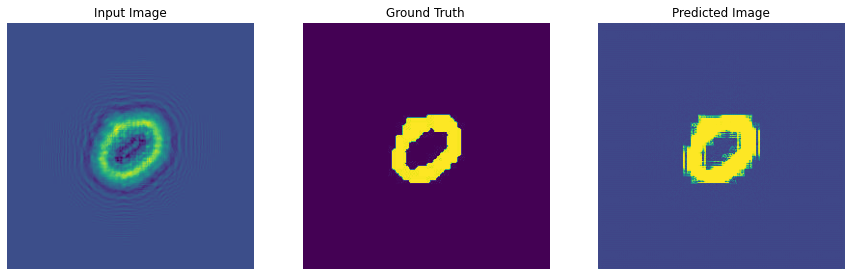

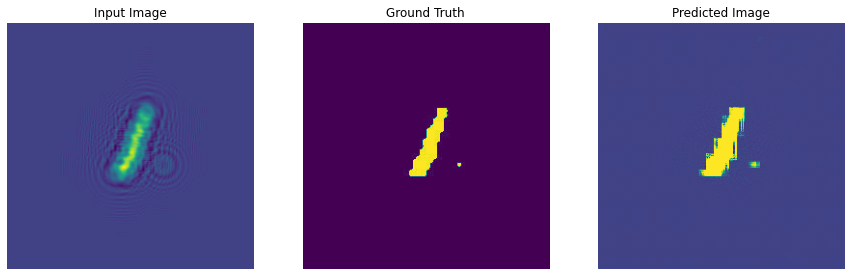

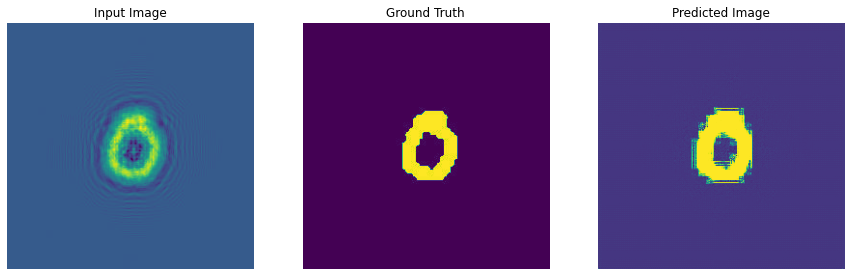

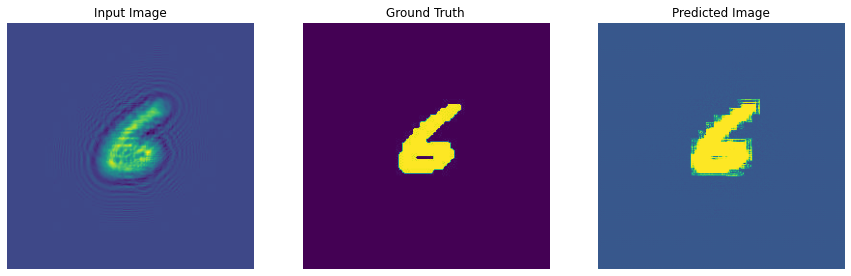

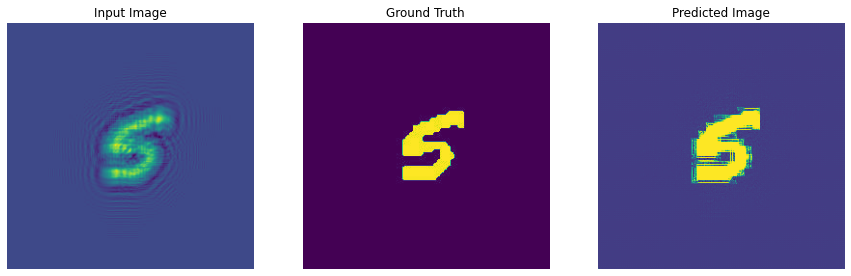

In [36]:
for inp, tar in test_dataset.take(5):
  img = generate_images(generator, inp, tar)

In [37]:
num_images = len(imgurls)
fake_target_images = [to_test_images(generator, inp, tar)[2] for inp, tar in test_dataset.take(num_images)]
real_target_images = [to_test_images(generator, inp, tar)[1] for inp, tar in test_dataset.take(num_images)]

zeros = np.zeros_like(fake_target_images[0])
fake_target_images = [cv2.merge((zeros, zeros, img)) for img in fake_target_images]
real_target_images = [(cv2.merge((zeros, zeros, img))*2/255)-1 for img in real_target_images]

In [38]:
geval = EvalGAN(real_target_images, fake_target_images)
#geval = EvalGAN(real_target_images, real_target_images)
fid = geval.calculate_fid()
print("Pix2Pix propagacón FID:", fid)

7/7 [==============================] - 42s 6s/step
Pix2Pix propagacón FID: 7.488215619173437


In [39]:
a = np.array([tf.image.ssim(real_target_images[i], fake_target_images[i], max_val=2.0) for i in range(num_images)])

In [40]:
a.mean()

0.0068698977

### Prueba a diferentes distancias.

In [10]:
i = 3
@tf.function()
def load_image1(filename, INPATH_REAL = PATH + '/DatasetPropagacion/hdata_set_R/dist_'+str(i), OUPATH = PATH + '/DatasetPropagacion/data_set'):
  inimgRe = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH_REAL+'/'+filename)), tf.float32)[...,:1]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH+'/'+filename)), tf.float32)[...,:1]

  return inimgRe, tgimg

**Cambiar el índice!**

In [11]:
imgurls = !ls -1 '/content/drive/MyDrive/Proyecto_Laboratorio_Avanzado_II/DatasetPropagacion/hdata_set_R/dist_3'

In [12]:
imgurls

['000.jpg',
 '001.jpg',
 '002.jpg',
 '003.jpg',
 '004.jpg',
 '005.jpg',
 '006.jpg',
 '007.jpg',
 '008.jpg',
 '009.jpg']

In [13]:
propagacion_dataset = tf.data.Dataset.from_tensor_slices(imgurls)

propagacion_dataset = propagacion_dataset.map(load_image1, num_parallel_calls=tf.data.experimental.AUTOTUNE)

propagacion_dataset = propagacion_dataset.batch(1)

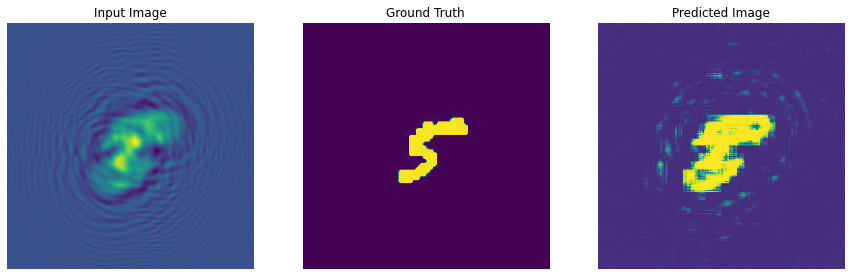

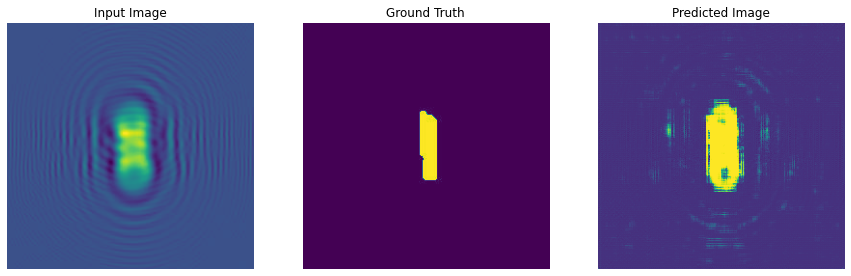

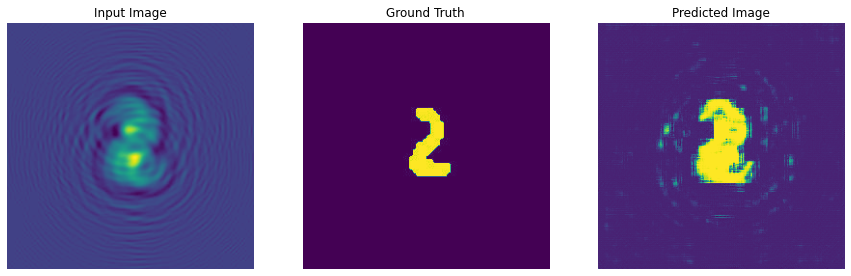

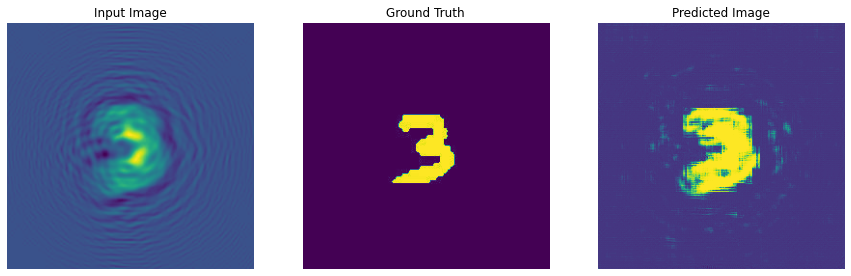

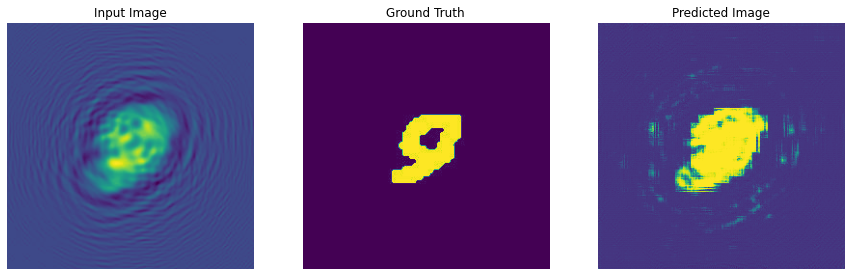

In [14]:
# Run the trained model on a few examples from the test set
for inp, tar in propagacion_dataset.take(5):
  img = generate_images(generator, inp, tar)

In [15]:
num_images = len(imgurls)
fake_target_images = [to_test_images(generator, inp, tar)[2] for inp, tar in propagacion_dataset.take(num_images)]
real_target_images = [to_test_images(generator, inp, tar)[1] for inp, tar in propagacion_dataset.take(num_images)]

zeros = np.zeros_like(fake_target_images[0])
fake_target_images = [cv2.merge((zeros, zeros, img)) for img in fake_target_images]
real_target_images = [(cv2.merge((zeros, zeros, img))*2/255)-1 for img in real_target_images]

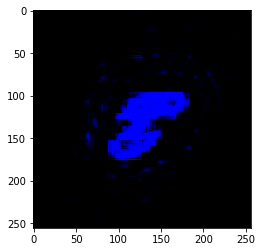

In [16]:
plt.imshow(fake_target_images[0])

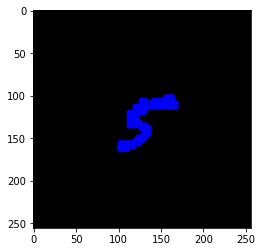

In [17]:
plt.imshow(real_target_images[0])

In [18]:
np.min(real_target_images[0]), np.max(real_target_images[0]), np.min(fake_target_images[0]),np.max(fake_target_images[0])

(-1.0, 1.0, -0.15701294, 1.0)

In [19]:
geval = EvalGAN(real_target_images, fake_target_images)
#geval = EvalGAN(real_target_images, real_target_images)
fid = geval.calculate_fid()
print("Pix2Pix propagacón FID:", fid)

1/1 [==============================] - 2s 2s/step
Pix2Pix propagacón FID: 6.897440427963875


In [20]:
a = np.array([tf.image.ssim(real_target_images[i], fake_target_images[i], max_val=2.0) for i in range(num_images)])

In [21]:
a.mean()

0.001986614

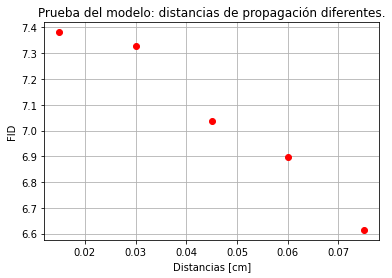

In [32]:
distancias = [0.015, 0.03, 0.045, 0.06, 0.075]
#fids_distancias = [320.00187086142626, 319.7490933729333, 319.57963759451485, 319.4130290306055, 319.20648305383713]
fids_distancias = [7.3813889319665575, 7.32980884353277, 7.035083544600367, 6.897440427963875, 6.6141553803708995]
SSIM = [0.0074615953, 0.0052482295, 0.0036246497, 0.001986614, 0.00037496217]

plt.plot(distancias, fids_distancias, 'ro')
plt.title('Prueba del modelo: distancias de propagación diferentes.')
plt.xlabel('Distancias [cm]')
plt.ylabel('FID')
plt.grid()

plt.savefig('fid_propagacion.png')

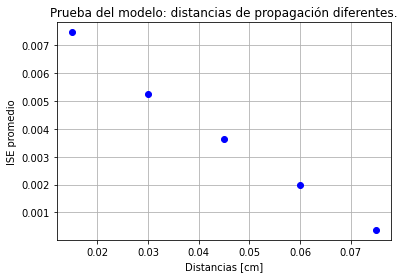

In [33]:
plt.plot(distancias, SSIM, 'bo')
plt.title('Prueba del modelo: distancias de propagación diferentes.')
plt.xlabel('Distancias [cm]')
plt.ylabel('ISE promedio')
plt.grid()

plt.savefig('ssim_propagacion.png')

### Prueba objetos complejos.

In [10]:
@tf.function()
def load_image2(filename, INPATH_REAL = PATH + '/DatasetComplejos/hdata_set_R', OUPATH = PATH + '/DatasetComplejos/data_set'):
  inimgRe = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH_REAL+'/'+filename)), tf.float32)[...,:1]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH+'/'+filename)), tf.float32)[...,:1]

  return inimgRe, tgimg

In [11]:
imgurls = !ls -1 '/content/drive/MyDrive/Proyecto_Laboratorio_Avanzado_II/DatasetComplejos/hdata_set_R'

In [12]:
imgurls

['000.jpg',
 '002.jpg',
 '003.jpg',
 '004.jpg',
 '005.jpg',
 '006.jpg',
 '007.jpg',
 '008.jpg',
 '009.jpg',
 '010.jpg']

In [13]:
complejos_dataset = tf.data.Dataset.from_tensor_slices(imgurls)

complejos_dataset = complejos_dataset.map(load_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)

complejos_dataset = complejos_dataset.batch(1)

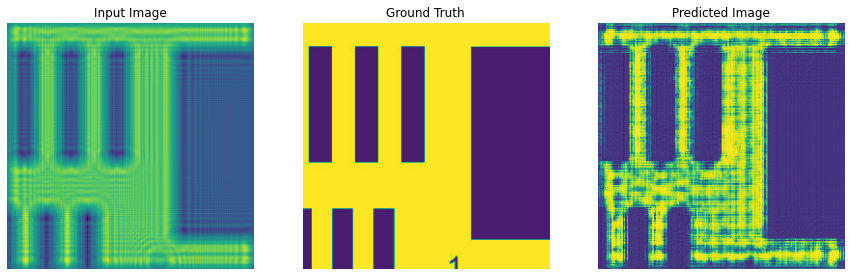

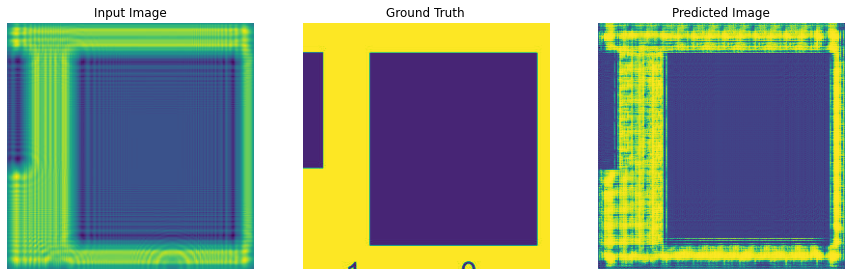

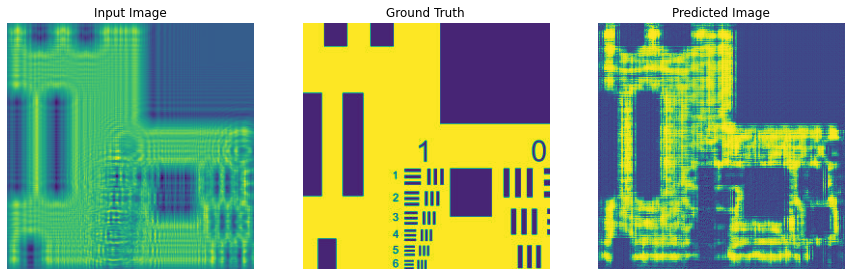

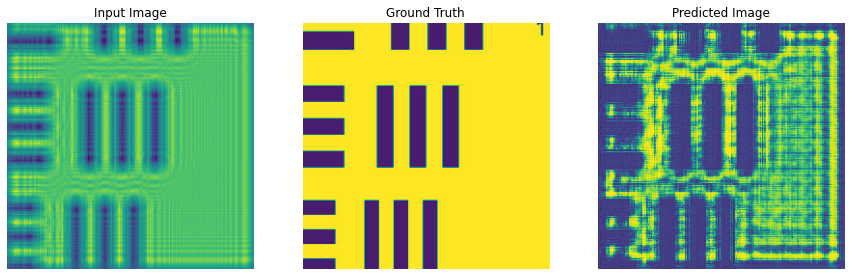

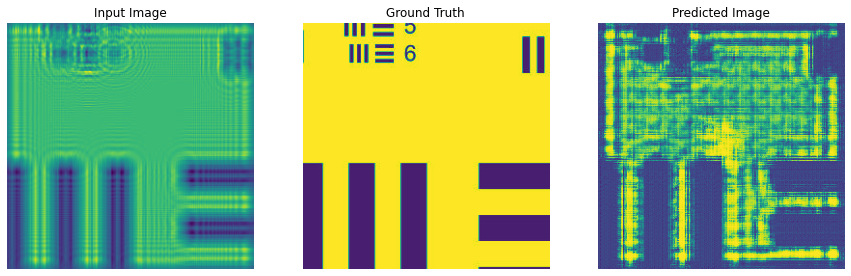

In [14]:
# Run the trained model on a few examples from the test set
for inp, tar in complejos_dataset.take(5):
  img = generate_images(generator, inp, tar)

In [15]:
num_images = len(imgurls)
fake_target_images = [to_test_images(generator, inp, tar)[2] for inp, tar in complejos_dataset.take(num_images)]
real_target_images = [to_test_images(generator, inp, tar)[1] for inp, tar in complejos_dataset.take(num_images)]

zeros = np.zeros_like(fake_target_images[0])
fake_target_images = [cv2.merge((zeros, zeros, img)) for img in fake_target_images]
real_target_images = [(cv2.merge((zeros, zeros, img))*2/255)-1 for img in real_target_images]

In [16]:
np.min(real_target_images[0]), np.max(real_target_images[0]), np.min(fake_target_images[0]),np.max(fake_target_images[0])

(-1.0, 1.0, -0.18359077, 0.9999547)

In [17]:
geval = EvalGAN(real_target_images, fake_target_images)
#geval = EvalGAN(real_target_images, real_target_images)
fid = geval.calculate_fid()
print("Pix2Pix propagacón FID:", fid)

1/1 [==============================] - 4s 4s/step
Pix2Pix propagacón FID: 4.282961487212931


In [18]:
a = np.array([tf.image.ssim(real_target_images[i], fake_target_images[i], max_val=2.0) for i in range(num_images)])

In [19]:
a.mean()

0.03053717

### Comparación métodos comunes.

In [10]:
@tf.function()
def load_image3(filename, INPATH_REAL = PATH + '/DatasetRealpart/hdata_set_R', OUPATH = PATH + '/DatasetRealpart/data_set'):
  inimgRe = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH_REAL+'/'+filename)), tf.float32)[...,:1]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH+'/'+filename)), tf.float32)[...,:1]

  return inimgRe, tgimg

@tf.function()
def load_image4(filename, INPATH_REAL = PATH + '/DatasetRealpart/hdata_set_R_rebuilt', OUPATH = PATH + '/DatasetRealpart/data_set'):
  inimgRe = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH_REAL+'/'+filename)), tf.float32)[...,:1]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH+'/'+filename)), tf.float32)[...,:1]

  return inimgRe, tgimg

In [11]:
imgurls = !ls -1 '/content/drive/MyDrive/Proyecto_Laboratorio_Avanzado_II/DatasetRealpart/hdata_set_R'

In [ ]:
imgurls

In [13]:
rebuilt_dataset = tf.data.Dataset.from_tensor_slices(imgurls)
model_dataset = tf.data.Dataset.from_tensor_slices(imgurls)

rebuilt_dataset = rebuilt_dataset.map(load_image4, num_parallel_calls=tf.data.experimental.AUTOTUNE)
model_dataset = model_dataset.map(load_image3, num_parallel_calls=tf.data.experimental.AUTOTUNE)

rebuilt_dataset = rebuilt_dataset.batch(1)
model_dataset = model_dataset.batch(1)

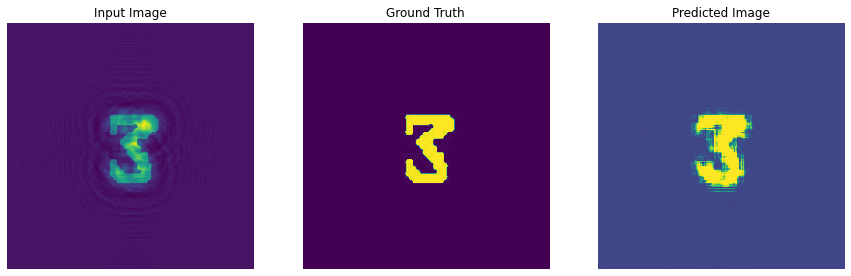

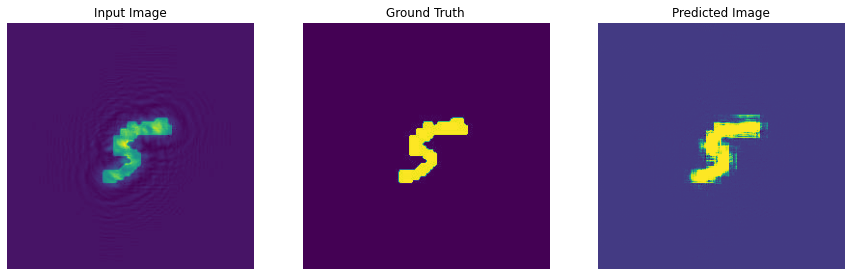

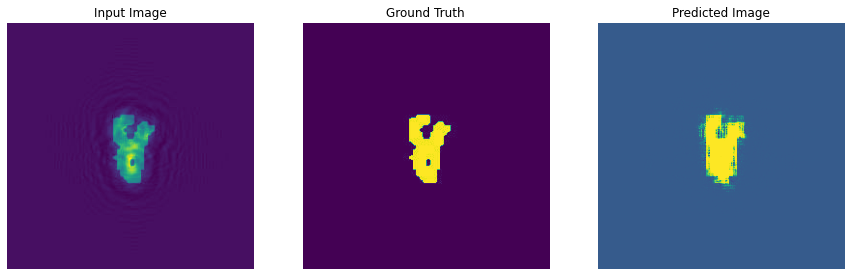

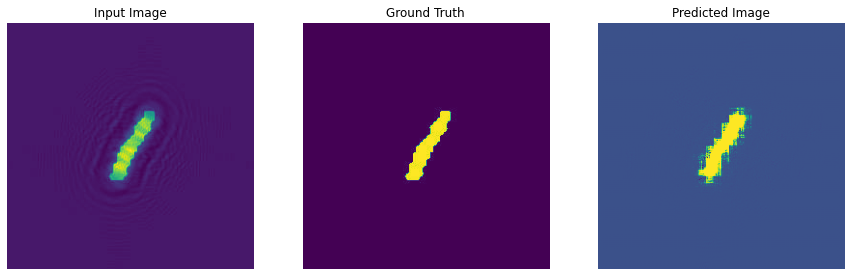

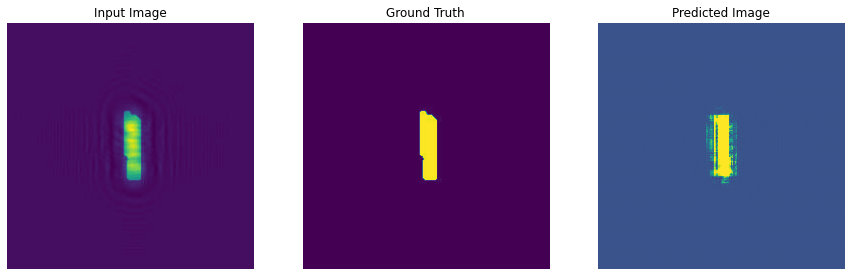

In [14]:
# Run the trained model on a few examples from the test set
for inp, tar in rebuilt_dataset.take(5):
  img = generate_images(generator, inp, tar)

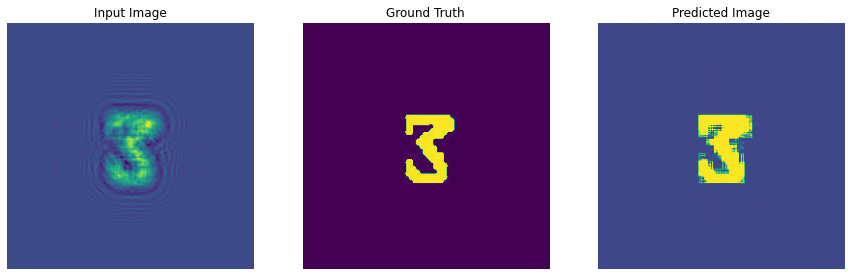

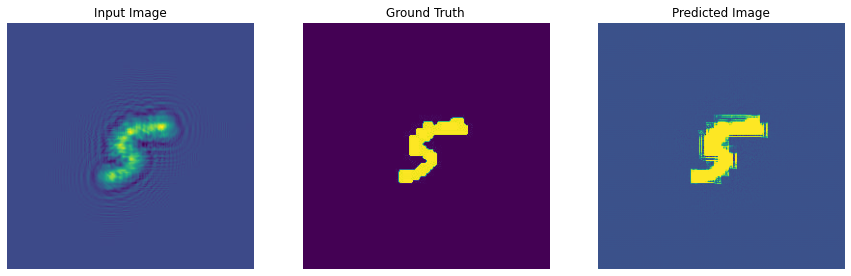

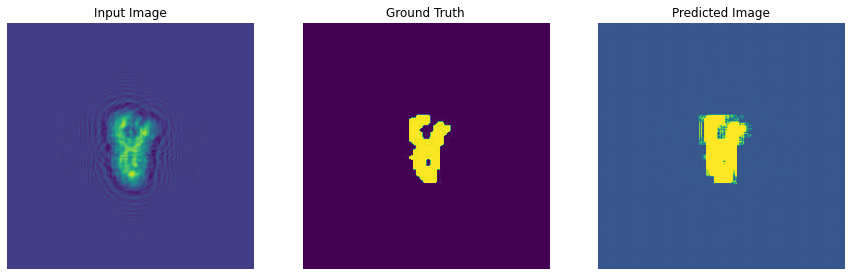

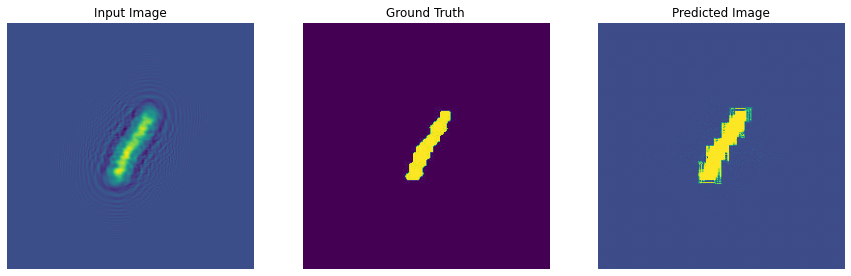

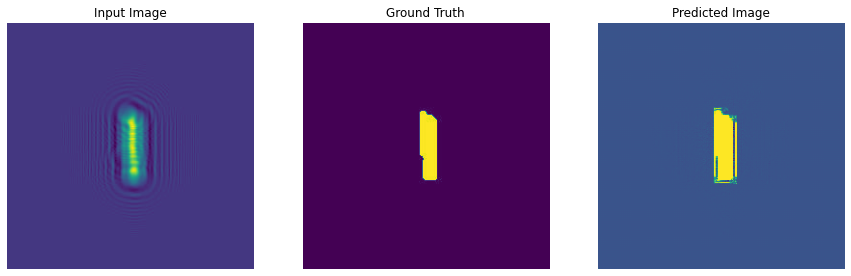

In [15]:
# Run the trained model on a few examples from the test set
for inp, tar in model_dataset.take(5):
  img = generate_images(generator, inp, tar)

In [16]:
num_images = len(imgurls)
fake_target_images_m = [to_test_images(generator, inp, tar)[2] for inp, tar in model_dataset.take(num_images)]
real_target_images_m = [to_test_images(generator, inp, tar)[1] for inp, tar in model_dataset.take(num_images)]

zeros = np.zeros_like(fake_target_images_m[0])
fake_target_images_m = [cv2.merge((zeros, zeros, img)) for img in fake_target_images_m]
real_target_images_m = [(cv2.merge((zeros, zeros, img))*2/255)-1 for img in real_target_images_m]

In [62]:
fake_target_images_r = [to_test_images(generator, inp, tar)[1] for inp, tar in rebuilt_dataset.take(num_images)]
real_target_images_r = [to_test_images(generator, inp, tar)[0] for inp, tar in rebuilt_dataset.take(num_images)]

#zeros = np.zeros_like(fake_target_images_m[0])
#fake_target_images_r = [cv2.merge((zeros, zeros, img)) for img in fake_target_images_r]
#real_target_images_r = [(cv2.merge((zeros, zeros, img))*2/255)-1 for img in real_target_images_r]

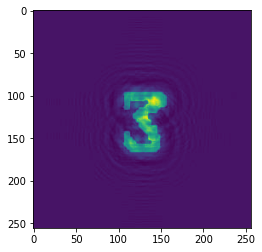

In [55]:
plt.imshow(real_target_images_r[0])

In [61]:
from skimage.metrics import structural_similarity

In [63]:
a_r = np.array([structural_similarity(real_target_images_r[i], fake_target_images_r[i], full=True)[0] for i in range(num_images)])

In [64]:
a_r.mean()

0.019801520665142246

In [ ]:
geval_r = EvalGAN(real_target_images_r, fake_target_images_r)
#geval = EvalGAN(real_target_images, real_target_images)
fid_r = geval_r.calculate_fid()
print("Pix2Pix reconstrucción FID:", fid_r)

In [ ]:
a_r = np.array([tf.image.ssim(real_target_images_r[i], fake_target_images_r[i], max_val=255) for i in range(num_images)])
a_r.mean()

In [17]:
geval_m = EvalGAN(real_target_images_m, fake_target_images_m)
#geval = EvalGAN(real_target_images, real_target_images)
fid_m = geval_m.calculate_fid()
print("Pix2Pix modelo FID:", fid_m)

1/1 [==============================] - 4s 4s/step
Pix2Pix modelo FID: 7.656452269117031


In [18]:
a = np.array([tf.image.ssim(real_target_images_m[i], fake_target_images_m[i], max_val=2.0) for i in range(num_images)])
a.mean()

0.0070753247

## Red